<a href="https://colab.research.google.com/github/Rripped/PromptRefining/blob/main/PromptRefining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: system message hinzufügen (whatsapp); in sys mess: originaler prompt, img mehr wie prompt, neuer prompt präziser

--> assistant, (moderation?)

-----------------------------------------------------------------------------


This notebook sends a prompt to ChatGPT 3.5 and creates images from scratch given a prompt as well as variations of given images. (See print statements at the end of the notebook)

If command fails, go to Runtime - Change Runtime type - GPU T4

In [13]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


necessary installs

In [14]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate
!pip install openai cohere tiktoken jq requests

necessary imports

In [15]:
import requests
import shutil
import os
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
from functools import cache
from PIL import Image
from IPython.display import display
import urllib.request
from io import BytesIO

In [16]:
client = OpenAI(api_key=os.environ["OAI"])

## Embedding
Initialize Embeddings functions

In [17]:
@cache
def get_embeddings(input: str):
    model = "text-embedding-ada-002"
    embeddings = client.embeddings.create(input=input, model=model)
    return embeddings.data[0].embedding

In [18]:
@cache
def generate_image(prompt):
  return client.images.generate(model="dall-e-2", prompt=prompt, size="256x256", quality="standard", n=1)

In [19]:
def get_image_url(image):
    return str(image.data[0].url)

In [20]:
def create_differences_for_image(initial_prompt, url):
    system_message = ("Compare an AI generated image with a matching prompt. "
        "State all differences of a prompt to the image in bulletpoints. "
        "Ignore artifacts not specified in the prompt. "
        "Return \"DONE\" if there are no differences.")
    generation = client.chat.completions.create(
    model="gpt-4-vision-preview",
    messages=[
          {
          "role": "system",
          "content": system_message

          },
        {
          "role": "user",
          "content": [
            {"type": "text", "text": initial_prompt},
            {
              "type": "image_url",
              "image_url": {
                "url": url,
              },
            },
          ]}
      ],
      max_tokens=150,
      #temperature=0.2,
      #top_p=0.3
    )
    return generation.choices[0].message.content


In [21]:
def generate_prompt_for_differences(previous_messages):
    system_message = "You are a prompt generator for images. You will get a list of differences for the generated image. Create a new prompt without negation for a new image that eliminates the differences and satisfies the initial prompt."
    messages = [
        {
            "role": "system",
            "content": system_message
        }
    ]
    messages += previous_messages
    generation = client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=messages
    )
    return generation.choices[0].message.content

In [22]:
def download(url, file_name):
    res = requests.get(url, stream = True)

    if res.status_code == 200:
      with open(file_name,'wb') as f:
        shutil.copyfileobj(res.raw, f)
      print('Image sucessfully downloaded: ', file_name)
    else:
      print('Image couldn\'t be retrieved')

In [23]:
def show_image(url):
    with urllib.request.urlopen(url) as url:
        image = Image.open(BytesIO(url.read()))
    display(image)

You will have to compare an AI generated image with an original prompt. The prompt is marked by the preceding tag [PROMPT].

The goal is to filter out all differences of a prompt to the image. Tagged by [DIFFERENCES] you will return a list of bulletpoints, with short differences between the prompt and the image. Be short and if no differences exist, leave the differences empty.

In a second paragraph marked with [NEW PROMPT], design a new prompt, which precisely filters out the differences, so that the new prompt can be used to create a new image, which is closer to the original prompt. In the end there should be no more things in the picture than asked for in the original prompt.

Provide no more information than defined here. Please answer with "Yes" if you understood.


You are given a prompt and an image. Your task is to improve the wording of the prompt so that Dall-E can generate a more realistic image of the given prompt. Respond with the newly generated prompt only.

Collect all embeddings in an array. We can then compare the embeddings of all steps and compute the similarity, e.g., the cosine similarity

Iteration 1:


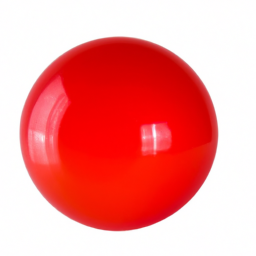

InternalServerError: Error code: 500 - {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID 8b7b27a56391f8a1acc2fcf2ebdaa08b in your email.)', 'type': 'server_error', 'param': None, 'code': None}}

In [24]:
def loop(initial_prompt, max_iteration_count):
    embeddings = []
    messages = [{
        "role": "user",
        "content": ""
    }, {
        "role": "assistant",
        "content": initial_prompt
    }]
    image = generate_image(initial_prompt)
    for i in range(max_iteration_count):
        url = get_image_url(image)
        #download(imageUrl, "output.png")
        print(f"Iteration {i + 1}:")
        # print(f"Image URL: {url}")
        show_image(url)
        differences = create_differences_for_image(initial_prompt, url)
        embeddings.append(get_embeddings(differences))
        print(f"Differences: {differences}")
        if differences == "DONE":
            return
        messages += [{
            "role": "user",
            "content": differences
        }]
        new_prompt = generate_prompt_for_differences(messages)
        messages += [{
            "role": "assistant",
            "content": new_prompt
        }]
        print(f"New prompt: {new_prompt}")
        image = generate_image(new_prompt)
    print(messages)
    return embeddings

embeddings = loop(initial_prompt="A red sphere on white background without shadows", max_iteration_count=5)

In [ ]:
embeddings